<a href="https://colab.research.google.com/github/NishaMDev/DeepLearning/blob/main/Assignment%236/DL_Assignment_6_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - supervised contrastive learning  - Using new loss 

Write a colab to demonstrate supervised contrastive learning loss based supervised classification versus regular softmax based one

In [1]:
!pip install tensorflow_addons

In [26]:
%load_ext autoreload
%autoreload 2
import datetime
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.8.0


In [10]:
%load_ext autoreload
%autoreload 2
#from contrast_loss_utils import *
from model import *
import losses

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# global configs
EPOCHS = 20
DATA = 'mnist-regression'
NORMALIZE_EMBEDDING = True
# NORMALIZE_EMBEDDING = False
N_DATA_TRAIN = 60000
# N_DATA_TRAIN = 10000
BATCH_SIZE = 32
PROJECTION_DIM = 128
WRITE_SUMMARY = False
ACTIVATION = 'leaky_relu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
!mkdir -p logs/

In [12]:
optimizer = tf.keras.optimizers.Adam()

## Load MNIST data

In [13]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [14]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [15]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Train baseline model

In [16]:
mlp = MLP(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

In [17]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [18]:
@tf.function
def train_step_baseline(x, y):
    with tf.GradientTape() as tape:
        y_preds = mlp(x, training=True)
        loss = cce_loss_obj(y, y_preds)

    gradients = tape.gradient(loss, 
                              mlp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  mlp.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)



In [19]:
@tf.function
def test_step_baseline(x, y):
    y_preds = mlp(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)


In [20]:
model_name = 'baseline'
if not NORMALIZE_EMBEDDING:
    model_name = 'baseline-no_norm'

if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)


In [21]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds:
        train_step_baseline(x, y)
        
    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        

    for x_te, y_te in test_ds:
        test_step_baseline(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        

    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.3615434169769287, Acc: 92.538330078125, Test Loss: 0.1554996818304062, Test Acc: 95.51000213623047
Epoch 2, Loss: 0.13030777871608734, Acc: 96.20500183105469, Test Loss: 0.11315251141786575, Test Acc: 96.52000427246094
Epoch 3, Loss: 0.09359020739793777, Acc: 97.1816635131836, Test Loss: 0.09983284771442413, Test Acc: 96.77999877929688
Epoch 4, Loss: 0.07389145344495773, Acc: 97.7933349609375, Test Loss: 0.09380190819501877, Test Acc: 97.05999755859375
Epoch 5, Loss: 0.061163149774074554, Acc: 98.11166381835938, Test Loss: 0.0971829742193222, Test Acc: 96.86000061035156
Epoch 6, Loss: 0.052804797887802124, Acc: 98.40333557128906, Test Loss: 0.09101305902004242, Test Acc: 97.16999816894531
Epoch 7, Loss: 0.04677198827266693, Acc: 98.55166625976562, Test Loss: 0.08169348537921906, Test Acc: 97.50999450683594
Epoch 8, Loss: 0.0399714931845665, Acc: 98.788330078125, Test Loss: 0.08564615994691849, Test Acc: 97.43999481201172
Epoch 9, Loss: 0.03482603281736374, Acc: 98.8933

In [22]:
# get the projections from the last hidden layer before output
x_tr_proj = mlp.get_last_hidden(x_train)
x_tr_proj.shape

TensorShape([60000, 256])

In [23]:
x_te_proj = mlp.get_last_hidden(x_test)
x_te_proj.shape

TensorShape([10000, 256])

In [24]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


### 1.2. Check learned embedding

In [27]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)

PCA(n_components=2)

In [28]:
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [29]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


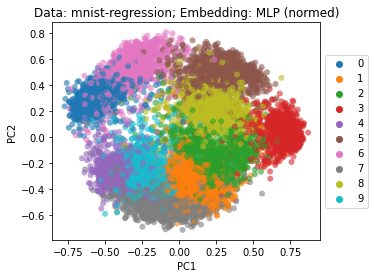

In [36]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
                    )

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: MLP'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: MLP (normed)'% DATA
ax.set_title(title);

#fig.savefig('/figs/PCA_plot_%s_MLP_last_layer.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


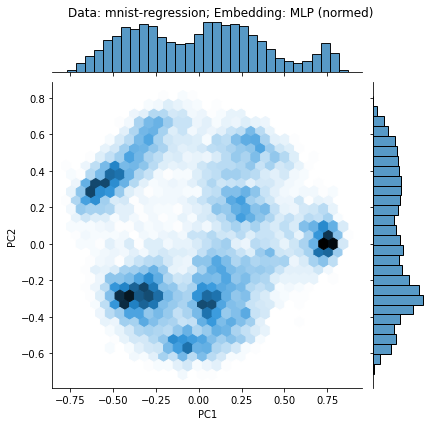

In [37]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
#g.savefig('figs/Joint_PCA_plot_%s_MLP_last_layer.png' % DATA)

## Stage 1: train encoder with contrastive loss

In [32]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)


In [33]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_contrast_MAE')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_contrast_MAE')


In [38]:
@tf.function
# train step for the contrast loss
def train_step_contrast(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = losses.max_margin_contrastive_loss(z, y, metric='cosine')

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))

    train_loss(loss)

In [39]:
@tf.function
def test_step_contrast(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = losses.max_margin_contrastive_loss(z, y, metric='cosine')
    test_loss(t_loss)

In [41]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
 #   train_bce.reset_states()
    test_loss.reset_states()
 #   test_bce.reset_states()

    for x, y in train_ds:
        train_step_contrast(x, y)

    for x_te, y_te in test_ds:
        test_step_contrast(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
#                         train_bce.result(),
                        test_loss.result(),
#                         test_bce.result()
                         ))


Epoch 1, Loss: 0.02365943230688572, Test Loss: 0.013089247047901154
Epoch 2, Loss: 0.012479915283620358, Test Loss: 0.011639606207609177
Epoch 3, Loss: 0.009893335402011871, Test Loss: 0.008422416634857655
Epoch 4, Loss: 0.008282661437988281, Test Loss: 0.008470016531646252
Epoch 5, Loss: 0.0069745550863444805, Test Loss: 0.0081106498837471
Epoch 6, Loss: 0.006434137932956219, Test Loss: 0.008406993001699448
Epoch 7, Loss: 0.005603281315416098, Test Loss: 0.007923202589154243
Epoch 8, Loss: 0.004938211757689714, Test Loss: 0.007830213755369186
Epoch 9, Loss: 0.004454907029867172, Test Loss: 0.007781487423926592
Epoch 10, Loss: 0.004242302849888802, Test Loss: 0.006117843557149172
Epoch 11, Loss: 0.003732929239049554, Test Loss: 0.007636795286089182
Epoch 12, Loss: 0.0034857268910855055, Test Loss: 0.006857299245893955
Epoch 13, Loss: 0.0031168528366833925, Test Loss: 0.0063261413015425205
Epoch 14, Loss: 0.0029801519121974707, Test Loss: 0.005914646200835705
Epoch 15, Loss: 0.002778984

In [42]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [43]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [44]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


## Check learned embedding

In [45]:
from sklearn.decomposition import PCA
# do PCA for the projected data


pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [46]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [47]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


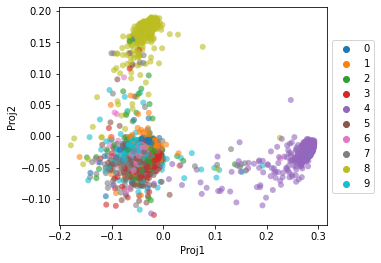

In [48]:
# x_te_proj_df.head()
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


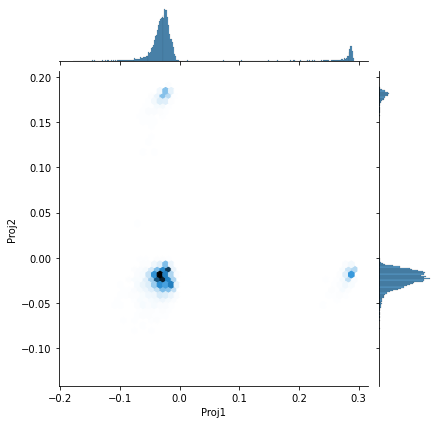

In [49]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );



In [50]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


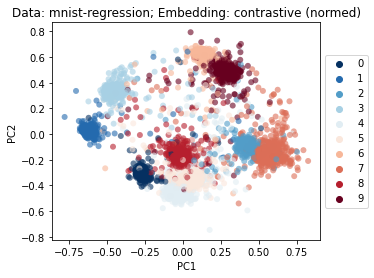

In [51]:
ax = sns.scatterplot('PC1', 'PC2', data=x_te_proj_pca_df,
#                 palette='tab10',
                     palette='RdBu_r',
                     legend='full',
                hue='label',
                linewidth=0,
                alpha=0.6
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


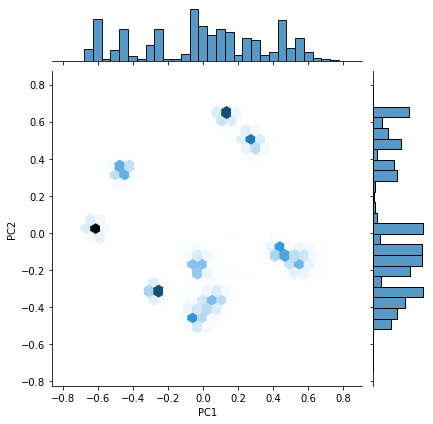

In [52]:
sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


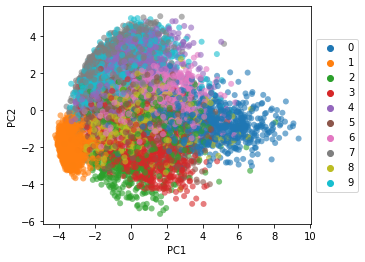

In [53]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


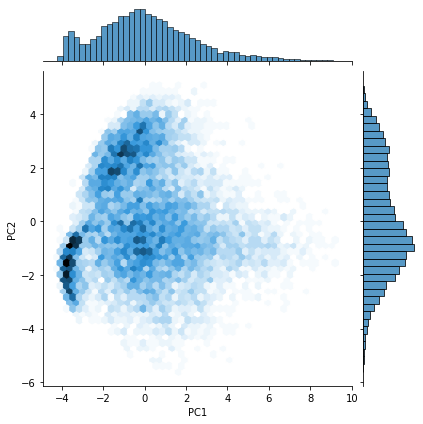

In [54]:
sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

## Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [55]:
softmax = SoftmaxPred()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)


In [56]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)

    t_loss = cce_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_acc(y, y_preds)
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)


In [57]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.22691212594509125, Acc: 97.5683364868164, Test Loss: 0.11570162326097488, Test Acc: 97.15999603271484
Epoch 2, Loss: 0.06957167387008667, Acc: 98.7750015258789, Test Loss: 0.08705989271402359, Test Acc: 97.6199951171875
Epoch 3, Loss: 0.047599032521247864, Acc: 99.14500427246094, Test Loss: 0.07585525512695312, Test Acc: 97.82999420166016
Epoch 4, Loss: 0.037084802985191345, Acc: 99.31999969482422, Test Loss: 0.06985567510128021, Test Acc: 97.93000030517578
Epoch 5, Loss: 0.031006375327706337, Acc: 99.45999908447266, Test Loss: 0.06636834889650345, Test Acc: 98.0
Epoch 6, Loss: 0.027098452672362328, Acc: 99.55000305175781, Test Loss: 0.06406718492507935, Test Acc: 98.06999969482422
Epoch 7, Loss: 0.02438986487686634, Acc: 99.61666107177734, Test Loss: 0.06250007450580597, Test Acc: 98.11000061035156
Epoch 8, Loss: 0.022386379539966583, Acc: 99.65499877929688, Test Loss: 0.06153295561671257, Test Acc: 98.11000061035156
Epoch 9, Loss: 0.02086460590362549, Acc: 99.6783294

In [58]:
test_acc.result().numpy() # default max margin contrastive loss

0.9833

In [59]:
test_acc.result().numpy() # max margin contrastive loss (cosine)

0.9833